In [1]:
import torch
import torchvision
import torchsummary

import argparse
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings

from utils import *

In [2]:
args = argparse.ArgumentParser()
# args.parse_args()

args.PATH = './'
args.DEVICE = 'cuda'
args.SIZE = 100

Train 1600, Val 400, Test 400


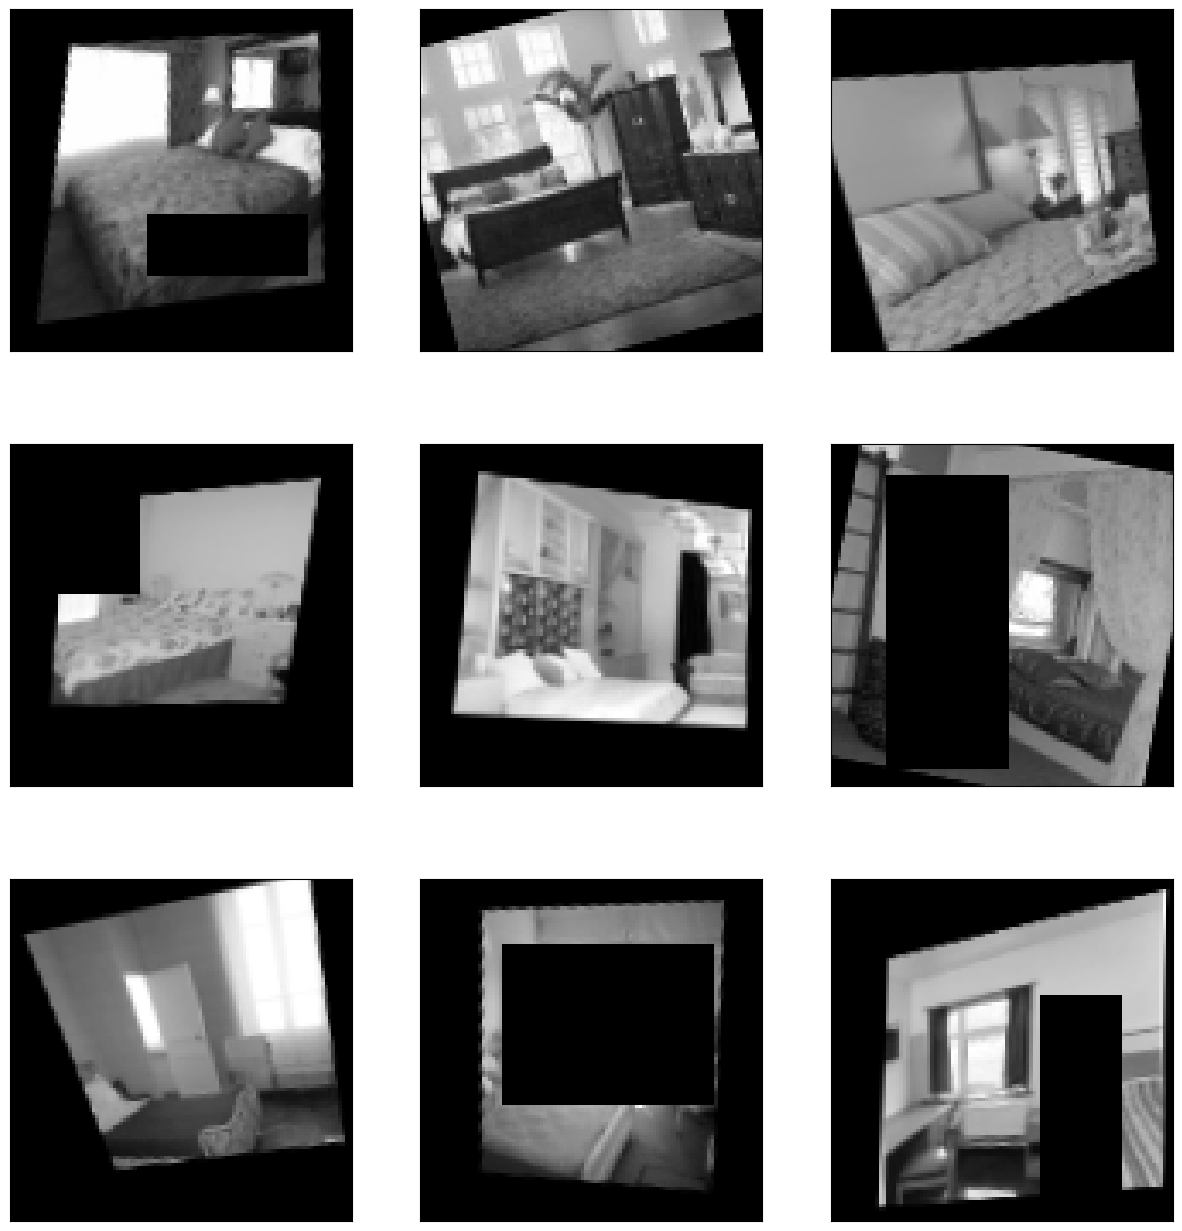

In [3]:
#--------------------------------------Transforms----------------------------------------
BILINEAR = torchvision.transforms.InterpolationMode.BILINEAR
Nomalization = torchvision.transforms.Compose([
    # torchvision.transforms.Resize((args.SIZE, args.SIZE), interpolation=BILINEAR),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])
Augmentation = torchvision.transforms.Compose([
    torchvision.transforms.RandomPerspective(interpolation=BILINEAR),
    torchvision.transforms.RandomRotation(15, interpolation=BILINEAR),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomErasing(),
])
Aug_preprocess = torchvision.transforms.Compose([Nomalization, Augmentation])
Nomal_preprocess = Nomalization
#--------------------------------------Load----------------------------------------
trn_data_org = torchvision.datasets.ImageFolder(args.PATH+'Data/scene/train/', transform=Nomal_preprocess)
trn_data_Aug = torchvision.datasets.ImageFolder(args.PATH+'Data/scene/train/', transform=Aug_preprocess)
tst_data = torchvision.datasets.ImageFolder(args.PATH+'Data/scene/test/', transform=Nomal_preprocess)
trn_data = trn_data_Aug
val_data = tst_data

args.classes = tst_data.find_classes(tst_data.root)[0]
args.num_trn_data = len(trn_data)
args.num_val_data = len(tst_data)
args.num_tst_data = len(tst_data)

print('Train {}, Val {}, Test {}'.format(len(trn_data), len(val_data), len(tst_data)))
#--------------------------------------Plot----------------------------------------
plt.figure(figsize=(15,16))
for i in range(9):
    inputs = trn_data[i][0].numpy()
    plt.subplot(331+i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose((inputs-np.min(inputs))/(np.max(inputs)-np.min(inputs)), (1,2,0)), cmap='gray')

In [4]:
#--------------------------------------Hyperparameter--------------------------------------
args.EPOCHS = 10000
args.BATCH_SIZE = 80
args.LR = 0.001

#---------------------------------------Import Model------------------------------------------
from models.Motified import Net
#--------------------------------------Load Checkpoint----------------------------------------
if os.path.exists(Path(args.PATH+'State/checkpoint.pt')):
    checkpoint = torch.load(args.PATH+'State/checkpoint.pt')
    args.SIZE = checkpoint['SIZE']
    model = checkpoint['model'].to(args.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_function = checkpoint['loss_function'].to(args.DEVICE)
    print('Back to training')
#--------------------------------------Select New Model---------------------------------------
else:
    checkpoint = None
    model = Net(1, 10, 100).to(args.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, weight_decay=1e-4)#RMSprop(model.parameters(), lr=LR)#SGD(model.parameters(), lr=LR)#
    loss_function = torch.nn.CrossEntropyLoss().to(args.DEVICE) # 把 Softmax–Log–NLLLoss合成一步, 如單獨使用 NLLLoss 需在最後一層加上 LogSoftmax
    print('New Model')
#-------------------------------------------Summary-------------------------------------------
torchsummary.summary(model, np.shape(trn_data[0][0].numpy()))

New Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             320
           Dropout-2         [-1, 32, 100, 100]               0
       BatchNorm2d-3         [-1, 32, 100, 100]              64
             PReLU-4         [-1, 32, 100, 100]              32
            Conv2d-5         [-1, 32, 100, 100]           9,248
           Dropout-6         [-1, 32, 100, 100]               0
       BatchNorm2d-7         [-1, 32, 100, 100]              64
             PReLU-8         [-1, 32, 100, 100]              32
            Conv2d-9         [-1, 16, 100, 100]           2,320
          Dropout-10         [-1, 16, 100, 100]               0
      BatchNorm2d-11         [-1, 16, 100, 100]              32
            PReLU-12         [-1, 16, 100, 100]              16
           Conv2d-13         [-1, 32, 100, 100]           9,248
          Dropout-14         

In [7]:
#--------------------------------------Dataset Loader--------------------------------------
trn_loader = torch.utils.data.DataLoader(dataset = trn_data, batch_size = args.BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = args.BATCH_SIZE)

#--------------------------------------Dataset Loader--------------------------------------
import training
training.run(args, model, loss_function, optimizer, checkpoint, trn_loader, val_loader)
load = model.model  

[    1/10000] Loss: 2.34839 Acc: 11.00% | 437ms per step | Val_loss: 2.80344 Val_acc: 10.00% | 104ms per step
[    2/10000] Loss: 2.20836 Acc: 12.50% | 413ms per step | Val_loss: 3.49568 Val_acc: 24.75% | 108ms per step
[    3/10000] Loss: 2.02956 Acc: 24.88% | 399ms per step | Val_loss: 2.61742 Val_acc: 37.25% | 96ms per step
[    4/10000] Loss: 1.90393 Acc: 29.31% | 419ms per step | Val_loss: 2.63275 Val_acc: 35.50% | 103ms per step
[    5/10000] Loss: 1.71650 Acc: 37.12% | 425ms per step | Val_loss: 2.23586 Val_acc: 37.25% | 106ms per step
[    6/10000] Loss: 1.55180 Acc: 38.88% | 424ms per step | Val_loss: 7.16326 Val_acc: 26.25% | 102ms per step
[    7/10000] Loss: 1.53860 Acc: 32.44% | 442ms per step | Val_loss: 2.08660 Val_acc: 50.25% | 109ms per step
[    8/10000] Loss: 1.38677 Acc: 50.19% | 419ms per step | Val_loss: 1.71577 Val_acc: 56.25% | 105ms per step
[    9/10000] Loss: 1.34065 Acc: 45.38% | 432ms per step | Val_loss: 1.72114 Val_acc: 53.25% | 117ms per step
[   10/1000

Checking CSP_mod5

Loss: 0.17090
Accuracy: 90.19%
Val_loss: 2.08259
Val_accuracy: 76.50%
Best_loss_Val_loss: 0.83455
Best_loss_Val_accuracy: 84.00%
Best_acc_Val_loss: 0.86546
Best_acc_Val_accuracy: 86.75%


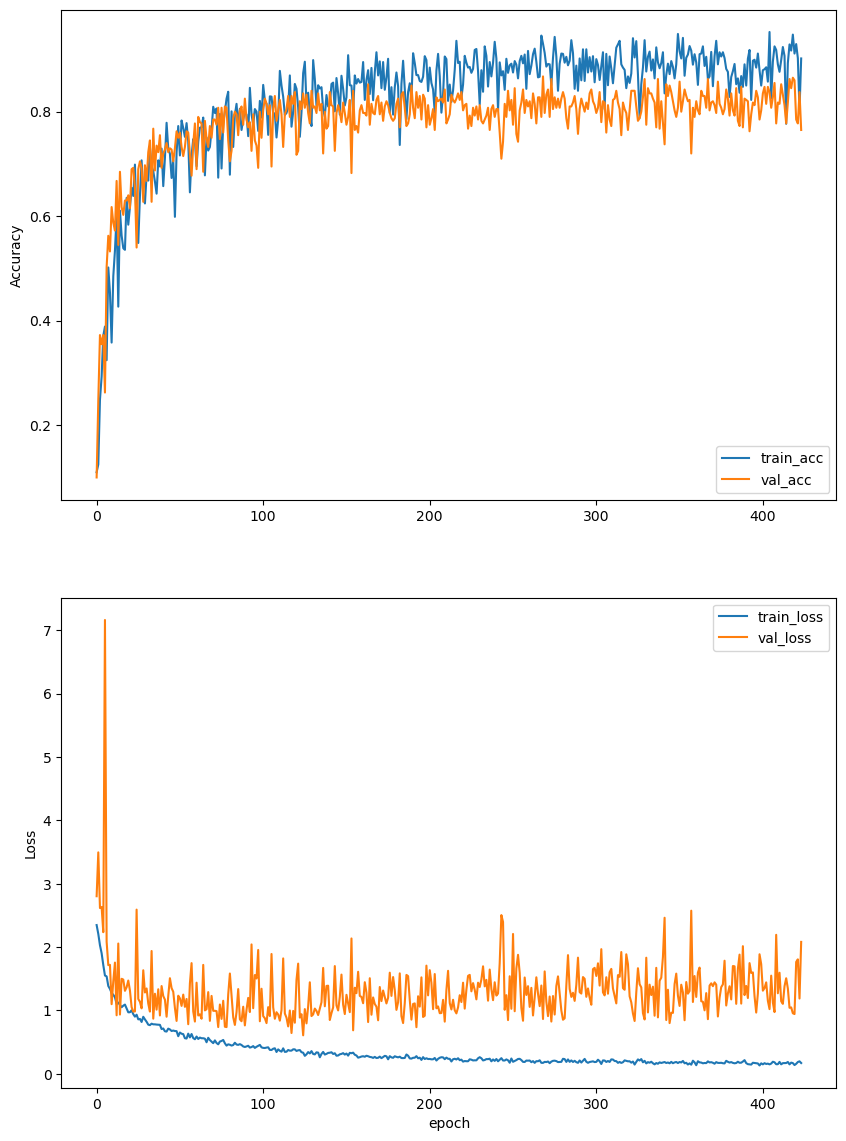

In [5]:
#-----------------------------------------Plot Training History------------------------------------------
load = load if 'load' in dir() else input('Load：')
if load != None:
    print('Checking', load)
    history = torch.load(args.PATH+'State/'+load+'/history.pt')
    best_history_loss = torch.load(args.PATH+'State/'+load+'/Best_loss_history.pt')
    best_history_acc = torch.load(args.PATH+'State/'+load+'/Best_acc_history.pt')
    model = torch.load(args.PATH+'State/'+load+'/model.pt')
    loss_history = history['loss_history']
    val_loss_history = history['val_loss_history']
    acc_history = history['acc_history']
    val_acc_history = history['val_acc_history']
    best_loss_val_loss = best_history_loss['val_loss']
    best_loss_val_acc= best_history_loss['val_acc']
    best_acc_val_loss = best_history_acc['val_loss']
    best_acc_val_acc= best_history_acc['val_acc']
    
    print('\nLoss: {:.5f}\nAccuracy: {:.2f}%\nVal_loss: {:.5f}\nVal_accuracy: {:.2f}%\nBest_loss_Val_loss: {:.5f}\nBest_loss_Val_accuracy: {:.2f}%\nBest_acc_Val_loss: {:.5f}\nBest_acc_Val_accuracy: {:.2f}%'.format(
            loss_history[-1], acc_history[-1], val_loss_history[-1], val_acc_history[-1], best_loss_val_loss, best_loss_val_acc, best_acc_val_loss, best_acc_val_acc))
    plt.figure(figsize=(10,14))
    plt.subplot(211)
    plt.plot(np.array(acc_history)/100)
    plt.plot(np.array(val_acc_history)/100)
    plt.ylabel('Accuracy', color='k')
    plt.legend(['train_acc', 'val_acc'], loc='lower right')
    plt.subplot(212)
    plt.plot(loss_history)
    plt.plot(val_loss_history)
    plt.xticks(color='k')
    plt.yticks(color='k')
    plt.ylabel('Loss', color='k')
    plt.xlabel('epoch', color='k')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.savefig(args.PATH+'State/'+model.model+'/history.png', facecolor='w')
    plt.show()
else:
    print("Error")

Evaluating 5/5
Normalized confusion matrix


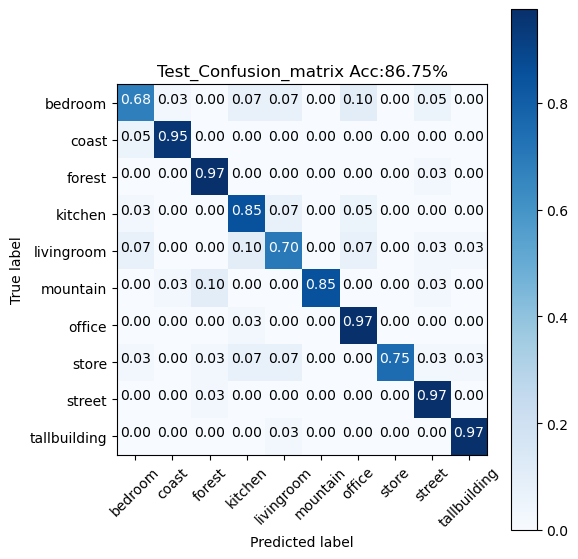

In [6]:
#-----------------------------------------Test Best Acc State of Model------------------------------------------
model.load_state_dict(torch.load(args.PATH+'State/'+load+'/Best_acc_state.pt'))
tst_loader = torch.utils.data.DataLoader(dataset = tst_data, batch_size = args.BATCH_SIZE)

tst_cmt, tst_acc = calculate_confusion_matrix(args, model, tst_loader)
plot_confusion_matrix(tst_cmt.cpu().numpy(), args.classes, tst_acc, True,'Test_Confusion_matrix', args.PATH+'State/'+model.model)

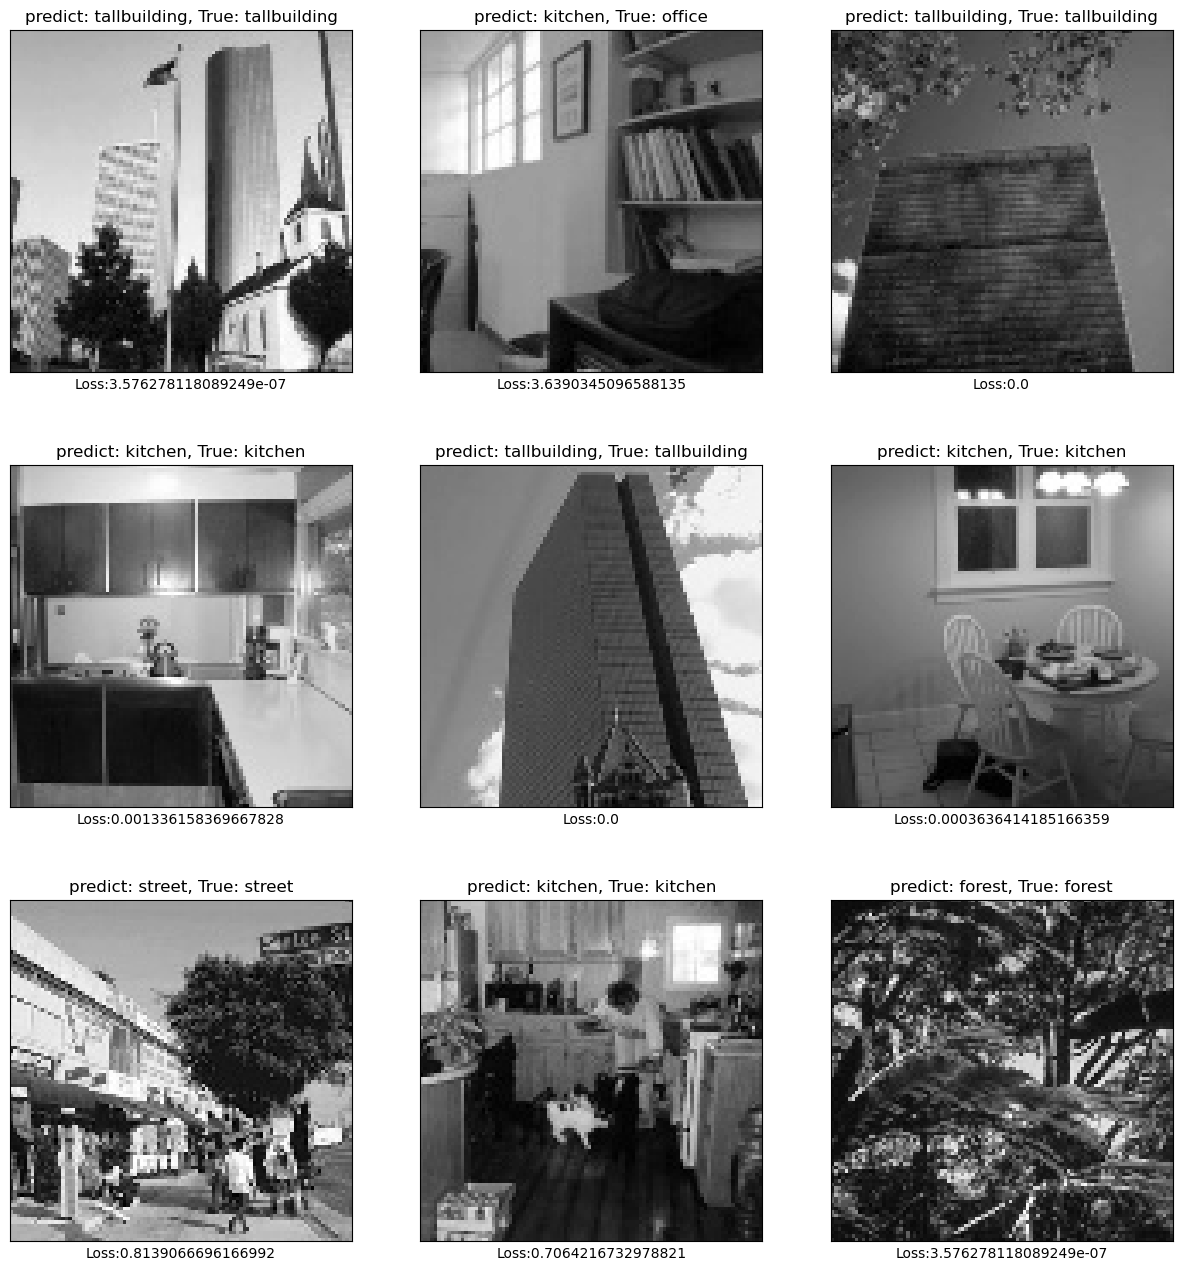

In [11]:
#-----------------------------------------Test Final Model------------------------------------------
torch.manual_seed(123)
test_data, _ = torch.utils.data.dataset.random_split(tst_data, [9, len(tst_data)-9])
test_loader = torch.utils.data.DataLoader(dataset = test_data)
test_loss, test_pred = plot_result(args, model, loss_function, test_loader, args.classes, args.PATH+'State/'+model.model+'/test.png')

In [11]:
del load

-------------------------------------------------------------------------------------